In [1]:
# The output of this cell should be committed to the repo such that the styles are applied after opening the notebook 

from IPython.core.display import HTML

with open("rise.css", "r") as f:
    styles = f.read()
HTML(f'<style>{styles}</style>')

<img src="images/aai_presentation_first_slide.svg" alt="Snow" style="width:100%;">
<div class="md-slide title">Anomaly Detection on Time Series</div>


In [2]:
import pandas as pd
import numpy as np

import matplotlib
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse

from statsmodels.graphics import tsaplots
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

matplotlib.rcParams['figure.figsize'] = (15, 5)


## Introduction to Time Series Analysis

---

**Definition:**
A time series is a series of data points indexed by time. Most often
the series contains points successively and equally spaced in time, e.g., every day, every month etc.

---
**Example:** Monthly beer production in Austria

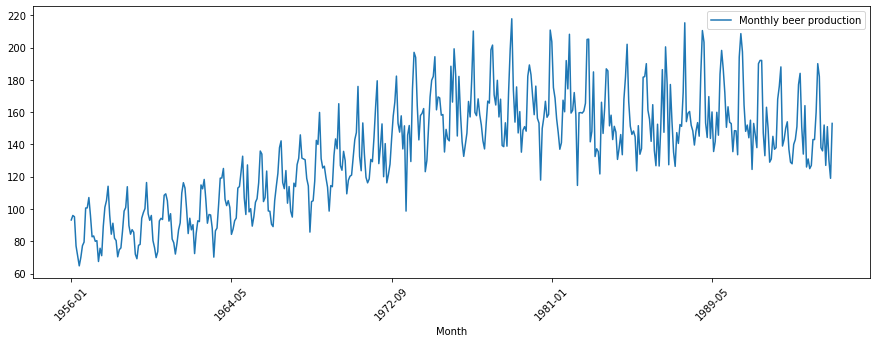

In [3]:
beer = pd.read_csv('../data/time_series/monthly-beer-production-in-austr.csv', index_col='Month')

beer.plot()
plt.xticks(rotation = 45)
plt.show()

# Why are Time Series Different?
- Random events that occur over time highly influence the future behavior of most time series $\Rightarrow$ time series
  can only be predicted to a limited extent.
- Spacial data is usually drawn independently, but the readings of a time series are correlated over time
  (autocorrelation).

In [4]:
def reg_forecast():
    fig, axes = plt.subplots(nrows=2, figsize=(10, 10))

    ax_reg = axes[0]
    axes_tmsrs = axes[1]

    # Regression
    f = lambda x: (.5 * x) + 2

    ax_reg.plot([0, 10], [f(0), f(10)])

    n_sample = 30
    X = np.random.rand(n_sample) * 10
    y = f(X) + np.random.normal(0, .5, n_sample) # Noisy measurements
    ax_reg.scatter(X, y, color='g')

    lin = LinearRegression()
    lin.fit(X.reshape(-1, 1), y)
    X_pred = np.array([[0], [10]])
    y_pred = lin.predict(X_pred)

    ax_reg.plot(X_pred, y_pred, 'r--')
    ax_reg.set_title('Regression')
    ax_reg.legend(['True Function', 'Estimated Function', 'Noisy Measurements'])
    # Time Series Forecasting
    n_sample = 30
    autoreg = lambda x: (np.array([.7, .1])*x).sum() + np.random.normal(0, 2)
    series = [5, 3, 1, 1, 1, 1, 5, 5, 3]
    for _ in range(n_sample-9):
        series.append(autoreg(np.array([series[-1] - series[-8], series[-2] - series[-9]])) + series[-7])

    series = pd.Series(series, index=pd.date_range("2018-01-01", periods=n_sample, freq="D"))
    series.plot(ax=axes_tmsrs)
    sarima = sm.tsa.statespace.SARIMAX(series, order=(2,0, 0), seasonal_order=(0, 1, 0, 7))
    res = sarima.fit()
    pred = res.get_prediction(start='2018-01-31', end='2018-02-28') #, dynamic='2018-02-01')
    pred.predicted_mean.plot(style='r--', ax=axes_tmsrs)
    conf_int = pred.conf_int()
    axes_tmsrs.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='r', alpha=.2)
    axes_tmsrs.set_title('Time Series Forecasting')
    axes_tmsrs.legend(['Past Readings', 'Forecast Mean', 'Forecast Confidence Interval'])
    plt.show()

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


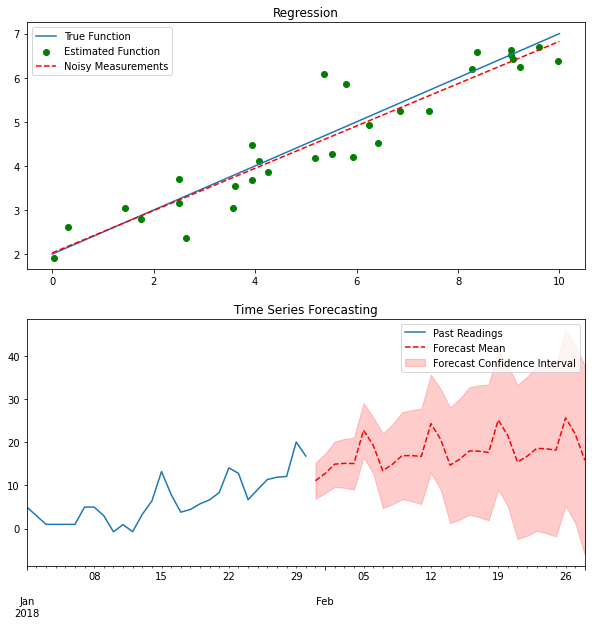

In [5]:
reg_forecast()

## Types of Anomalies
Because of the special nature time series, we need to distinguish different types of anomalies
- Point anomalies
- Context anomalies + change points
- Pattern anomalies

## Point Anomalies
If a point differs substantially from the rest of the data, we speak of a point anomaly.

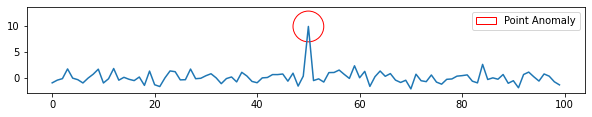

In [6]:
_, ax = plt.subplots(figsize=(10, 5))
sample = np.random.normal(0, 1, 100)
sample[50] = 10
ax.plot(sample)
circ = plt.Circle((50, 10), radius=3, color='red', fill=False)
ax.add_patch(circ)
ax.set_aspect('equal')
ax.legend([circ], ['Point Anomaly'])
plt.show()

## Context Anomalies and Change Points
- Context anomalies appear abnormal in their context but could be normal readings in a different context.
- Change points mark a regime shifts in the underlying data generation process.
Time series with regime shifts are one example where context anomalies can appear, but they can also be fond when the time series
shows for instance a seasonal pattern.

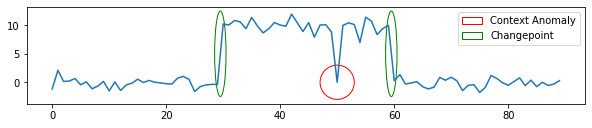

In [7]:
_, ax = plt.subplots(figsize=(10, 5))
sample = np.random.normal(0, 1, 30)
sample = np.concatenate([sample, np.random.normal(10, 1, 30)])
sample = np.concatenate([sample, np.random.normal(0, 1, 30)])
sample[50] = 0

ax.plot(sample)
circ_anml = plt.Circle((50, 0), radius=3, color='red', fill=False)
ax.add_patch(circ_anml)
circ_chngpnt = Ellipse((29.5, 5), width=2, height=15, color='green', fill=False)
ax.add_patch(circ_chngpnt)
circ_chngpnt = Ellipse((59.5, 5), width=2, height=15, color='green', fill=False)
ax.add_patch(circ_chngpnt)
ax.legend([circ_anml, circ_chngpnt], ['Context Anomaly', 'Changepoint'])
ax.set_aspect('equal')
plt.show()

## Pattern Anomalies
Also, a pattern formed by several points might be anomalous while the individual points don't show abnormal readings.

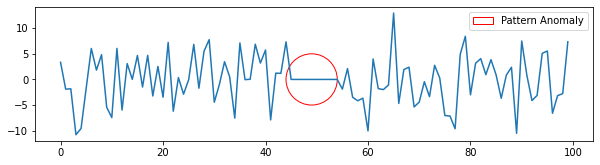

In [8]:
_, ax = plt.subplots(figsize=(10, 5))
sample = np.random.normal(0, 5, 45)
sample = np.concatenate([sample, np.zeros(10)])
sample = np.concatenate([sample, np.random.normal(0, 5, 45)])
sample[50] = 0

ax.plot(sample)
circ = plt.Circle((49, 0), radius=5, color='red', fill=False)
ax.add_patch(circ)
ax.set_aspect('equal')
ax.legend([circ], ['Pattern Anomaly'])
plt.show()


## Time Series as Stochastic Processes
A time series can often be seen as a realization of a stochastic process where each observation is a realization of a
random variable $(X_t)_{t\in \mathbb{N}}$.
Important properties:
- $E[X_t]$
- $\mathrm{Var}[X_t] = E[(X_t - E[X_t])^2]$
- $\mathrm{Cov}[X_t, X_{t'}] = E[(X_t - E[X_t])(X_{t'} - E[X_{t'}])]$


## Stationarity
A central property in time series analysis is *stationary*.

---
**Definition:** A time series is (covariance) stationary if the following three conditions are fulfilled:
- Constant Mean: $E[X_t] = \mu$ $\forall t\in \mathbb{N}$
- Constant variance: $\mathrm{Var}[X_t] = \sigma^2 $ $\forall t\in \mathbb{N}$
- Time invariant covariance: $\mathrm{Cov}[X_t, X_{t+k}] = \lambda_k$ $\forall t,k\in \mathbb{N}$
---

## Why Stationarity?
**Example**: Simple autoregressive Processes (AR(1))
The difference between stationary and non-stationary processes can understood by
considering processes of the form $X_t = \phi X_{t-1} + \epsilon_{t}$ where the $\epsilon_t$
normally distributed i.i.d. variables.
Depending on the value of $\phi$ we get very different behaviors:
- $|\phi| > 1$: explosive process (non-stationary but rarely observed in practice)
- $|\phi| = 1$: random walk (non-stationary)
- $|\phi| < 1$: stationary process

## Stationary vs Non-Stationary Time Series
The latter two cases are the relevant ones in practice. Let us have a look at the following processes:
- $X_t = X_{t-1} + \epsilon_t$
- $Y_t = \frac{4}{5} Y_{t-1} + \epsilon'_t$

where $\epsilon_t, \epsilon'_t\sim \mathcal{N}(0, 1)$ are independent white noise processes.
We simulate both processes several times with the same initial condition $X_0=Y_0=25$

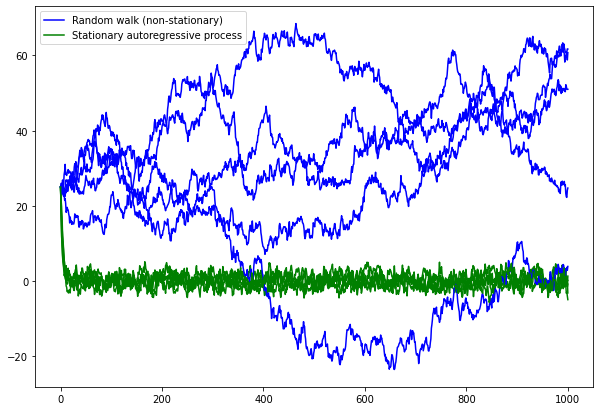

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))

for _ in range(5):
    # random walk
    walk = [25]
    for i in range(1000):
        walk.append(walk[-1] + np.random.normal(0, 1))

    # stationary time series
    series = [25]
    for i in range(1000):
        series.append((4/5) * series[-1] + np.random.normal(0,1))

    ax.plot(walk, color='b')
    ax.plot(series, color='g')
    ax.legend(labels=['Random walk (non-stationary)', "Stationary autoregressive process"], loc='upper left')
plt.show()

## Stationary vs Non-Stationary Time Series
While a stationary process always reverts to its mean ($0$ for $Y_t$), the non-stationary random walk can move
unpredictably in any direction. This is because the random events of past do not wear off over time in a random walk.
Hence, the variance increases over time which makes it hard to define anomalous behavior.
Indeed,

- $E[X_{t+k} \mid X_t] = X_t$ but
- $\lim_{k\to\infty}E[Y_{t+k} \mid Y_t] = 0$.

**Question:** Can you explain why the expectations behave that way?

## Stationary vs Non-Stationary Time Series
In these situations it is often a better idea to analyze the white noise process $\epsilon_t$.
In our example we can rearrange the definition of $X_t$ to get

<center>

$\epsilon_t = X_t - X_{t-1}$
</center>

The *lag* operator is defined as $L(X_t) = X_{t-1}$. Using the lag operator we can write the above equation as

<center>

$\epsilon_t = (1-L)X_t$

</center>

We will see that this operation plays a special role in time series analysis. First let us see what this does to our
random walk.

## Stationary vs Non-Stationary Time Series

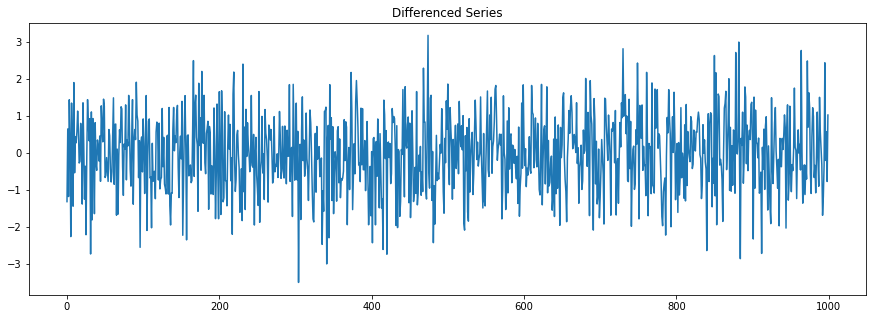

In [10]:
w0 = np.array(walk[1:]) - np.array(walk[:-1])
plt.plot(w0)
plt.gca().set_title("Differenced Series")
plt.show()

We see a pure white noise process with a well defined behavior.

Although many algorithms assume stationarity of the time series, in practice it is more common to find non-stationary
time series. Probably the most common cause for non-stationarity are trends and seasonality. In the following we will
discuss methods to identify and remove them from a time series.

## Trends
---
**Definition**
A trend in a time series is a tendency to move to relatively higher (or lower) values that is observed over a
long period of time.

---

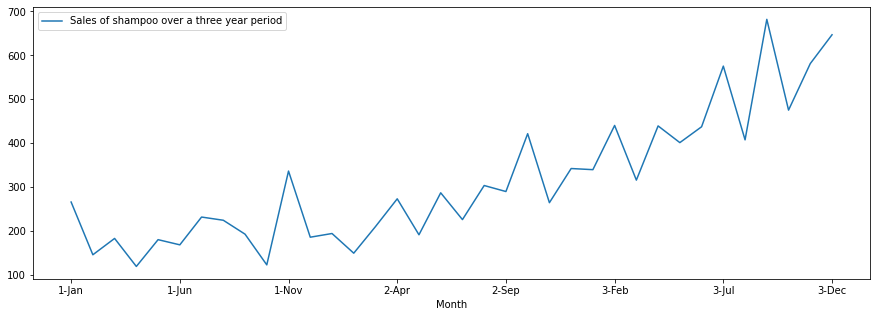

In [11]:
shampoo = pd.read_csv('../data/time_series/sales-of-shampoo-over-a-three-ye.csv', index_col='Month')

shampoo.plot()
plt.show()

### Removing Trends
The trend at time $t$ can be estimated by a moving average.

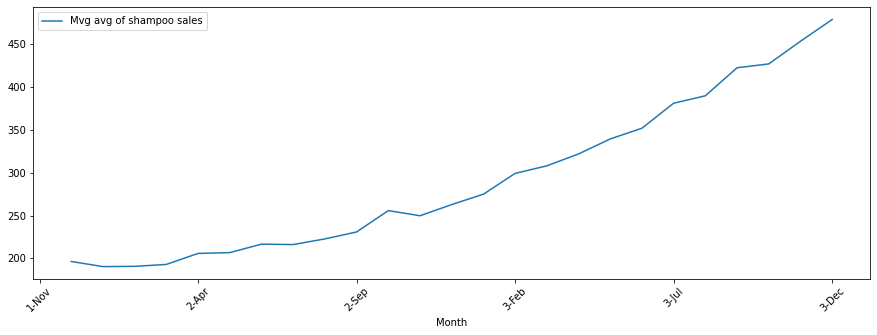

In [12]:
shampoo_mvgavg = shampoo.rolling(window=12).mean()
shampoo_mvgavg.columns = ['Mvg avg of shampoo sales']
shampoo_mvgavg.plot()
plt.xticks(rotation = 45)
plt.show()

**Question:** How would you describe the trend? How would you approach removing it?

## Removing Trends
We can remove trends from a time series through differencing. The differencing operator $\nabla$ is defined as

\begin{align*}
  \nabla(X_t) &= (1 - L)X_t \\
              &= X_t - L(X_t) \\
              &= X_t - X_{t-1}
\end{align*}

$L(X_t) = X_{t-1}$ is the *lag operator*. The $k$th order differenced time series can hence is

\begin{align*}
  \nabla^k(X_t) &= (1 - L)^kX_t \\
              &= \sum_{i=0}^k (-1)^i{k \choose i} L^iX_t
\end{align*}

- If a time series has a linear trend then the differenced time series will have no trend.
- More generally, if a time series has a kth order polynomial trend the k-fold differenced time series will have no trend.

We take our shampoo sales example and apply the differencing operator

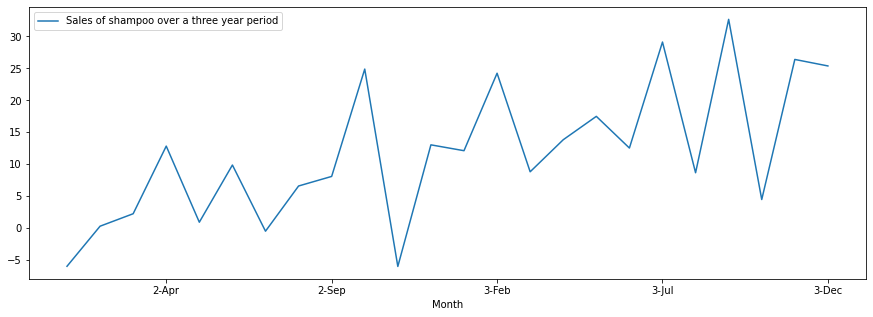

In [13]:
shampoo_dif = shampoo - shampoo.shift(1) # shift(k) ~ L^k

# Estimate trend
shampoo_dif.rolling(12).mean().plot()
plt.show()

We can see that there is still a linear trend in the series. Therefore, we apply the 2nd order differencing operator.

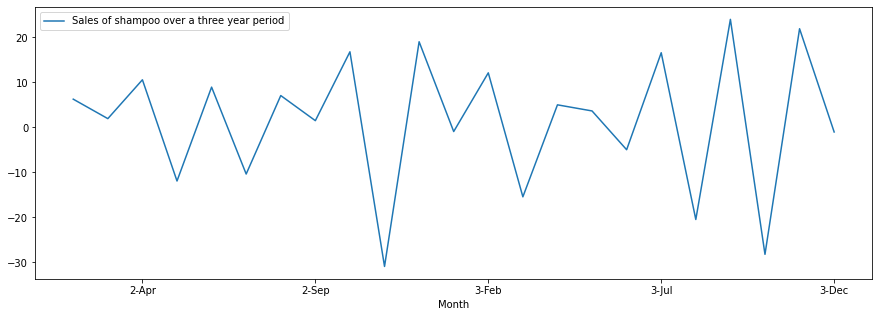

In [14]:
shampoo_dif = shampoo - 2*shampoo.shift(1) + shampoo.shift(2) # (1-L)^2 = 1 - 2*L + L^2

# Estimate trend
shampoo_dif.rolling(12).mean().plot()
plt.show()

Now there is no trend apparent anymore. This is consistent with our initial inspection of the data


## Seasonalities
---
**Definition:**
A seasonality is a cyclic behavior with a fixed interval length, e.g. a year, a month, etc.

---
**Example:** Minimum daily temperature in Melbourne, Australia

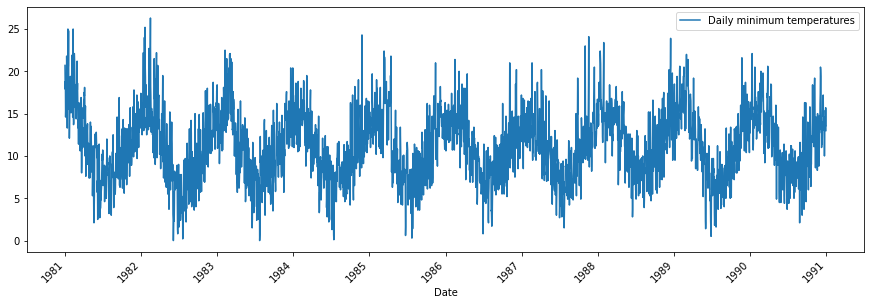

In [15]:
temperatures = pd.read_csv('../data/time_series/daily-minimum-temperatures-in-me.csv', index_col='Date')
temperatures.index = pd.to_datetime(temperatures.index)

temperatures.plot()
plt.xticks(rotation = 45)
plt.show()

The time series has a clear 12-month seasonality.

### Removing Seasonalities
Seasonalities can be identified using the *autocorrelation function (acf)*. The acf describes the
correlation between a variable and lagged version of itself, that is for stationary process
with constant mean $\mu$ and constant variance $\sigma^2$

$\mathrm{acf}_X(k) = Corr(X_t, X_{t+k}) = \frac{E[(X_t - \mu)(X_{t+k} -\mu)]}{\sigma^2}$

We take a look at the acf of our temperatures dataset. Before we apply the acf, we remove leap days so that every
year has 365 days.

In [16]:
temperatures_noleap = temperatures.loc[~((temperatures.index.month == 2) & (temperatures.index.day == 29))]

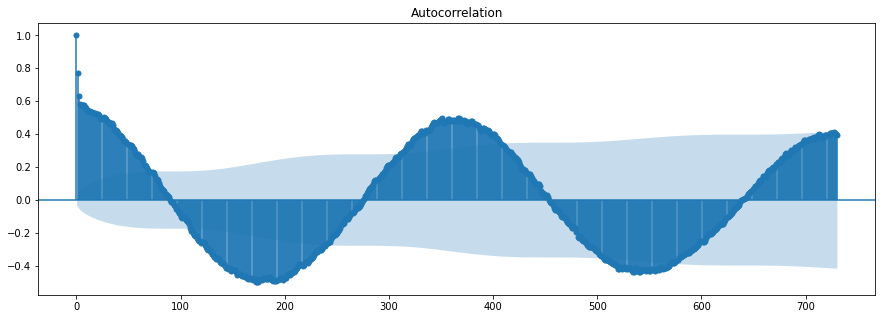

In [17]:
fig = tsaplots.plot_acf(temperatures_noleap, lags=2*365)
plt.show()

### Removing Seasonalities
In the acf we can clearly see the annual periodicity. We can remove the annual periodicity through lag-k differencing.
$$\nabla_kX_t = (1 - L^k)X_{t}$$

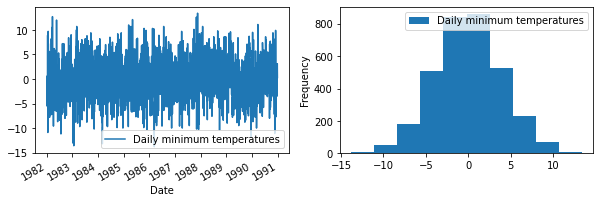

In [18]:
temperatures_dif = temperatures_noleap.diff(365)
#temperatures_dif.columns = ['Adjusted temperatures']

fig, axes = plt.subplots(ncols=2, figsize=(10, 3))
ax0, ax1 = axes

temperatures_dif.plot(ax=ax0)
temperatures_dif.plot(ax=ax1, kind='hist')
plt.show()

### Removing Seasonalities
After differencing of the time series, it looks approximately like a white noise process (i.e., all samples are drawn
independently of a fixed Gaussian distribution).
Computing the acf for the adjusted time series should show no significant auto correlation.

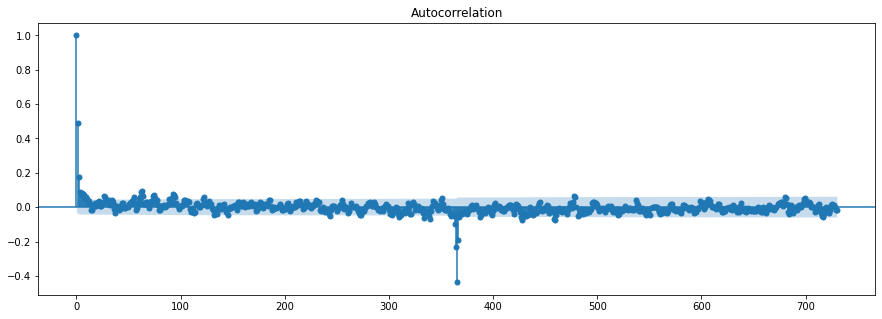

In [19]:
fig = tsaplots.plot_acf(temperatures_dif.dropna(), lags=2*365)
plt.show()

## Summery
- Time series data differs from point data in the sense that the readings are in general not independent of each other.
- Stationarity is a central concept in time series analysis.
- A time series can contain trends and seasonalities which demand special attention when one tries to identify anomalies.
- Differencing is one class of time series transformations which allows eliminating trends and seasonalities.

## Forcasting
A very common approach for anomaly detection on time series is based on forecasting.
The idea is that a good forecasting model should be able to predict the next reading rather accurately
if no anomaly appears. An anomaly, however, should not be predictable accurately. Therefore, we can use the prediction
error as anomaly score.

## The SARIMA Model
The SARIMA model is a very popular and well researched method for time series forecasting. The name SARIMA can be
decomposed as follows:

- S: Seasonal
- AR: Autoregressive
- I: Integrated
- MA: Moving Average

## The AR Model
A purely autoregressive model represents the current reading as a linear combination of past readings and a
nondeterministic error. It is specified as $\mathrm{AR}(k)$ where k denotes the number of past readings to consider.
Hence, the representation of the $\mathrm{AR}(1)$ model that we have seen previously

$X_t - \phi_1X_{t-1} = \epsilon_t$ (or equivalently $(1- \phi_1L)X_t = \epsilon_t$)

is a special case of the $\mathrm{AR}(k)$ representation:

$$ \left(1 - \sum_{i=1}^{k}\phi_iL^i\right)X_t = \epsilon_t $$

**Stationarity:**
An $\mathrm{AR}$ process $(1 - \sum_{i=1}^{k}\phi_iL^i)X_t = \epsilon_t$ is stationary if all roots of the
characteristic polynomial $(1 - \sum_{i=1}^{k}\phi_iz^i)$ over the complex numbers lie outside the unit circle.

## The MA Model
The moving average model expresses the reading at time $t$ as a weighted average of past error terms.
Hence, $\mathrm{MA}(1)$ is written as

$$ X_t = \epsilon_t + \psi_1 \epsilon_{t-1} $$

and in general $\mathrm{MA}(k)$

$$ X_t = \left(1 + \sum_{i=1}^k \psi_iL^i\right)\epsilon_t $$

**Stationarity:**
$\mathrm{MA}$ models are always stationary.

**Question:** Do you see why?

### Example

Consider the hypothetical sales of earthquake survival kits. After an earthquake sales increase, but the effect lasts off
over time.

Say the strength of the strongest earthquake in the region over a year has a binomial distribution, and the sales
motivated by this years earthquake season are proportional to the strength. We might model the situation as follows:
- $\epsilon_t \sim 1000 \cdot \textrm{Binomial}(.5)$
- $X_t = \epsilon_t + \sum_{i=1}^5 .9^i\epsilon_{t-i}$

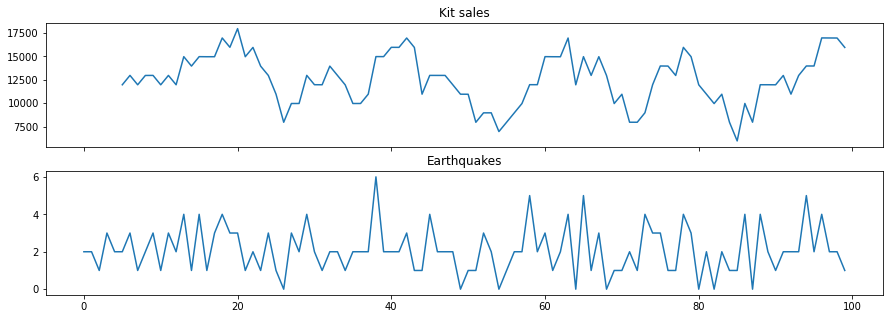

In [20]:
shocks = np.abs(np.random.binomial(10, 0.2, 100))
sales = [sum([shocks[t-lag]* 1000 * (.999**lag) for lag in range(6)]) for t in range(5, len(shocks))]

_, axes = plt.subplots(nrows=2, sharex='all')

ax = axes[0]
ax.plot(np.arange(5, len(shocks)), sales)
ax.set_title("Kit sales")

ax=axes[1]
ax.set_title('Earthquakes')
ax.plot(shocks)

plt.show()

## The ARMA Model
Both models can be combined building the $\mathrm{ARMA}(p, q)$ model:

$$ \left(1 - \sum_{i=0}^p\phi_i L^i\right)X_t = \left(1 + \sum_{j=1}^q \psi_j L^j\right)\epsilon_t $$

**Idea:** Correct the autoregressive model using past prediction errors. For instance a local tendency to predict to
low values can be corrected by adding an average of the last few prediction errors

## The ARIMA Model
It is advisable to apply ARMA models only to stationary time series. In fact most implementation enforce by default the
model to be stationary. In case of a non-stationary time series
we need the extensions to the ARIMA model.
First, the $\mathrm{ARIMA}(p, d, q)$ model applies d-th order differencing before applying $\mathrm{ARMA}(p, q)$
to remove trends from the time series

$$ \left(1 - \sum_{i=0}^p\phi_iL^i\right)(1-L)^dX_t = \left(1 + \sum_{j=1}^q \psi_jL^j\right)\epsilon_t $$

## Modeling of Seasonal influences
Seasonal ARIMA further extends the model by seasonal term and is specified as $\mathrm{SARIMA}(p, d, q)(P, D, Q)_m$.
The parameter $p$, $d$, and $q$ have the same meaning as in $\mathrm{ARIMA}(p, d, q)$ and $P$, $D$, and $Q$ are there
seasonal counterparts. Explicitly
- $P$ is the number of seasonal lags in the autoregressive part.
- $D$ is the order of seasonal differencing that is applied.
- $Q$ is the number of seasonally lagged error terms for the moving average part.
- $m$ is the period of the seasonality.


To obtain the full model the seasonal terms are simply multiplied by the non-seasonal terms. That means
$\mathrm{SARIMA}(p, d, q)(P, D, Q)_m$ can be written as

\begin{align*}
  &\phantom{=..} \left(1 - \sum_{i=0}^p\phi_iL^i\right)\left(1 - \sum_{i=0}^P\Phi_iL^{im}\right)(1-L)^d(1-L^m)^DX_t \\
  &= \left(1 + \sum_{j=1}^q \psi_jL^j\right)\left(1 + \sum_{j=1}^Q \Psi_jL^{jm}\right)\epsilon_t
\end{align*}


## Fitting a SARIMA Model
Finding the right SARIMA model for a given time series requires a bit of experience. In the following we are going to
review some available techniques on NYC taxi passengers data set. This data set contains the number of taxi
passengers in New York City in 30 minute time intervals.

There are at least five known anomalies in the data set. These are:
- NYC Marathon - 2014-11-02
- Thanksgiving - 2014-11-27
- Christmas - 2014-12-25
- New Years - 2015-01-01
- Snow Blizzard - 2015-01-26 and 2015-01-27


First, we inspect the data visually.

In [44]:
df = pd.read_csv(
    '../data/nyc_taxi/nyc_taxi.csv',
    index_col='timestamp'
)

df.index = pd.to_datetime(df.index)

## Fitting a SARIMA Model

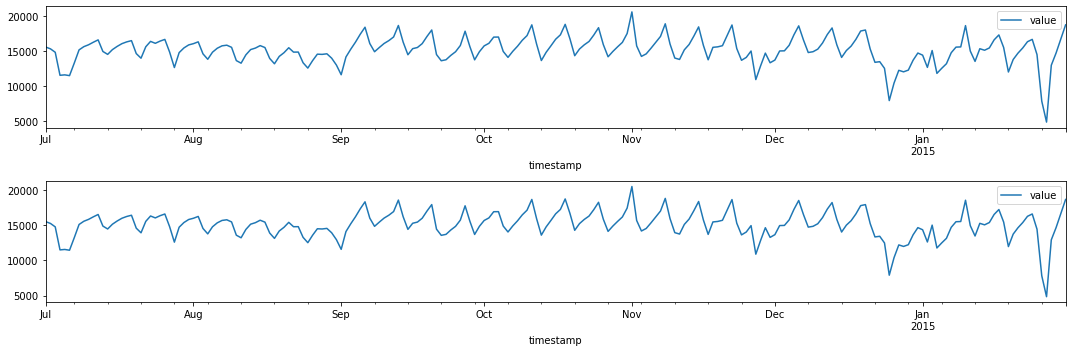

In [47]:
_, axes = plt.subplots(nrows=2)

df.plot(ax=axes[0])
df.iloc[:7*48].plot(ax=axes[1])

plt.tight_layout()
plt.show()

## Fitting a SARIMA Model
Since our anomalies are specified on day level, we resample our dataset to a one-day resolution

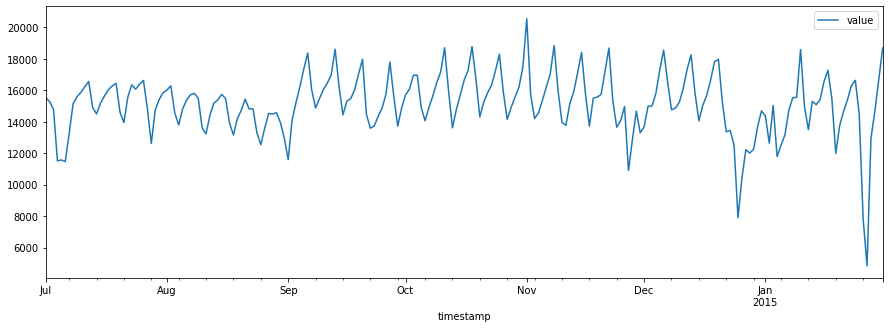

In [46]:
df = df.resample('1D').mean()
df.plot()
plt.show()

## Fitting a SARIMA Model
There is no obvious trend in the data, but we can observe a seasonal pattern. Next, we try to determine good values for
$p, q, P, Q$ and $m$ using the ACF and PACF plots. Some useful rules of thumb are:
- $q$: Take the first point where the ACF plot meets the significance threshold.
- $p$: Take the point where the PACF plot first meets the significance threshold.
- $m$: Take the point with the highest value in the ACF plot.
- $P$: Take $P \geq 1$ if the ACF at $m$ is positive else $0$.
- $Q$: Take $Q\geq 1$ if the ACF at $m$ is negative else $0$.
- $D$: Choose $D=1$ if the seasonal pattern (if present) is stable over time and else $D=0$.
- Usually $d+D \leq 2$ and $P+Q\leq 2$.

*Note*: If we would observe a trend in the data then we would first difference the series until the trend disappears
before we compute the ACF and PACF plots. The order of differencing equals the $d$ value in our SARIMA model.

## Fitting a SARIMA Model
- We have already observed a stable seasonal pattern $\Rightarrow$ $D=1$
- We plot the ACF:

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/axes/_base.py:2475: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


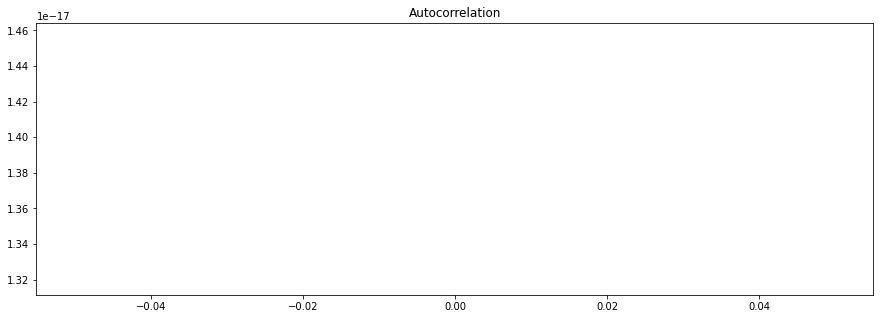

In [24]:
fig, ax = plt.subplots()
tsaplots.plot_acf(df, lags=48, ax=ax)
plt.show()

**Question:** Try to determine the period of the seasonal pattern

- In the first plot we observe that the highest correlation is at a lag of $7$ days $\Rightarrow$ $m=7$.
- The correlation at $m$ is positive hence we assume $P \geq 1$ and $Q=0$.

## Fitting a SARIMA Model
We apply seasonal differencing to find a value for $q$

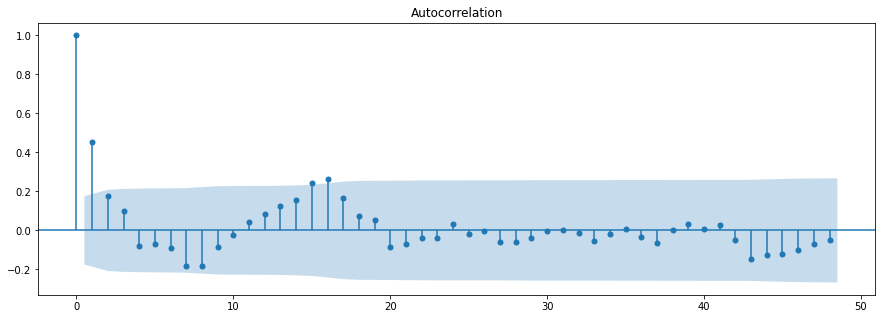

In [25]:
fig, ax = plt.subplots()
tsaplots.plot_acf(df.diff(7).dropna(), lags=48, ax=ax)
plt.show()

**Question:** Try to determine the order of the moving average.

- We see in the second plot that the autocorrelation meets the significance threshold at a lag of $3$ $\Rightarrow$
  $q=3$.

## Partial Autocorrelation Function
A related and also important function is the *partial autocorrelation function (pacf)*. The pacf measures the
conditional correlation between a variable, and the lagged versions of itself given that we know the values of all lagged
versions in between. For stationary processes:

$\mathrm{pacf}(k) = \frac{\mathrm{Cov}(X_t, X_{t+k} \mid X_{t+1}, \ldots, X_{t+k-1})}{\sqrt{\mathrm{Var}(X_t\mid X_{t+1},
    \ldots, X_{t+k-1})\mathrm{Var}(X_{t+k}\mid X_{t+1}, \ldots, X_{t+k-1})}}$

The pacf is better suited to choose values for $p$ since a purely autoregressive process of order $k$ has
$\mathrm{pacf}(\ell) = 0$ for all $\ell > k$.

Next, we plot the PACF for our series.

## Fitting a SARIMA Model

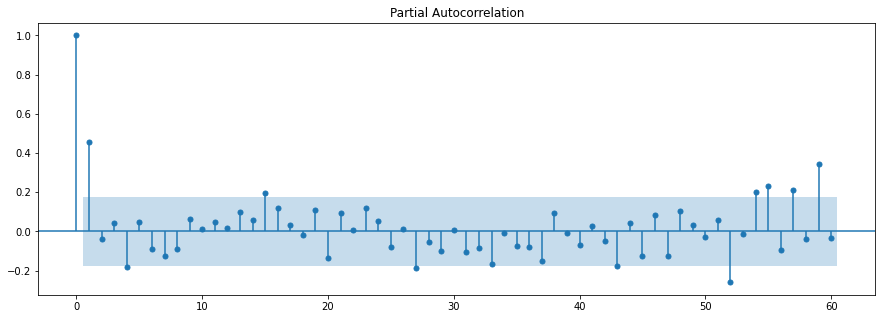

In [26]:
fig, ax = plt.subplots()
tsaplots.plot_pacf(df.diff(7).dropna(), lags=60, ax=ax)
plt.show()

**Question:** Try to determine the order of the autoregressive part.

- The PACF plot falls below the significance threshold after lag $1$ $\Rightarrow$ $p=1$

We conclude that $\mathrm{SARIMA}(1,0,3)(1,1,0)_{7}$ might be a good model for our time series.

## Fitting a SARIMA Model
Finally, we fit the model on our data

In [27]:
model = sm.tsa.statespace.SARIMAX(df, order=(1, 0, 3), seasonal_order=(1, 1, 0, 7))
result = model.fit(disp=False)
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              value   No. Observations:                  694
Model:             SARIMAX(1, 0, 3)x(1, 1, [], 7)   Log Likelihood               -1888.496
Date:                            Mon, 14 Mar 2022   AIC                           3788.992
Time:                                    14:41:27   BIC                           3816.186
Sample:                                01-07-2014   HQIC                          3799.514
                                     - 12-01-2015                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4974      0.228      2.186      0.029       0.051       0.943
ma.L1          0.0732      0.227      0.323      0.747      -0.371       0.517
ma.L2         -0.0914      0.165     -0.554      0.579      -0.415       0.232
ma.L3          0.2532      0.120      2.114      0.034       0.018       0.488
ar.S.L7       -0.4771      0.060     -7.955      0.000      -0.595      -0.360
sigma2      2.737e+06   2.15e+05     12.714      0.000    2.32e+06    3.16e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              6173.44
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.05   Skew:                            -0.88
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Fitting a SARIMA Model
We can use one step ahead prediction on our time series to perform anomaly detection.
Statsmodels provides a confidence interval with the prediction based on the estimated variance of the error terms.
We mark a point as anomaly if the true value falls outside the confidence interval of the prediction.

In [28]:
prediction = result.get_prediction(start='2014-07-14')
prediction_mean = prediction.predicted_mean
prediction_ci = prediction.conf_int()

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


ValueError: Can only compare identically-labeled Series objects

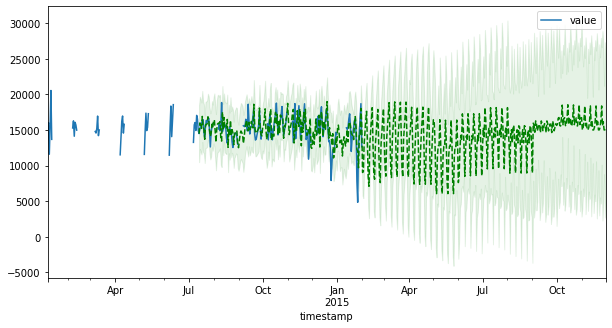

In [29]:
_, ax = plt.subplots(figsize=(10,5))
df.plot(ax=ax)
prediction_mean.plot(style='g--', ax=ax)
ax.fill_between(prediction_ci.index, prediction_ci.iloc[:,0], prediction_ci.iloc[:,1], color='g', alpha=0.1)

threshold = (prediction_ci.iloc[:,1] - prediction_mean)
mask = (prediction_mean - df['value'].iloc[14:]).abs() > threshold
outlier = df.iloc[14:][mask]
ax.scatter(outlier.index, df.loc[outlier.index], color='r')
plt.show()

## Fitting a SARIMA Model
We compare the list of known anomalies with our detection
- NYC Marathon - 2014-11-02
- Thanksgiving - 2014-11-27
- Christmas - 2014-12-25
- New Years - 2015-01-01
- Snow Blizzard - 2015-01-26
- Snow Blizzard - 2015-01-27

In [33]:
outlier

,value
timestamp,
2014-11-27,10899.666667
2014-12-04,15795.895833
2014-12-25,7902.125000
2015-01-01,14383.479167
2015-01-02,12639.916667
2015-01-26,7818.979167
2015-01-27,4834.541667
2015-01-28,12947.562500


**Question:** Compare our result and the known anomalies. Do you spot anything notable?

# Summary
We have learned a simple way of choosing a SARIMA model for a given time series:
- Determine the period of possible seasonality.
- Find the order of (seasonal) differencing that is necessary to make the time series stationary.
- Determine candidates for $q, P, Q$ from the acf plot.
- Determine candidates for $p$ from the pacf plot

## Implementations
- Statsmodels: [statsmodels.tsa.statespace.sarimax.SARIMAX](https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html)

### Other Time Series Analysis Packages
- Prophet: [time series forecasting](https://facebook.github.io/prophet/)
- Orbit: [Bayesian time series forecasting](https://github.com/uber/orbit)

<img src="images/aai_presentation_last_slide.svg" alt="Snow" style="width:100%;">
<div class="md-slide title">Thank you for the attention, this concludes the A.D. training. </div>
<div class="md-slide title">We will be happy to see you in another Transferlab training soon!</div>